In [1]:
import nltk
import string
from nltk.stem.porter import PorterStemmer

nltk.download('punkt')

stemmer = PorterStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    no_punc_trans = str.maketrans('', '', string.punctuation)
    tokens = nltk.word_tokenize(text.translate(no_punc_trans))
    stems = stem_tokens(tokens, stemmer)
    return stems

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [3]:
data_path = os.path.join(os.getcwd(), '..', 'data', 'to_analyse')
dataset = load_files(data_path, shuffle=False)
print("n_samples: %d" % len(dataset.data))
print(dataset.target)
print(dataset.target_names)

n_samples: 4533
[0 0 0 ..., 1 1 1]
['hit', 'miss']


In [4]:
dataset.data = dataset.data[:5000]
dataset.target = dataset.target[:5000]
print("n_samples: %d" % len(dataset.data))

n_samples: 4533


In [5]:
dataset.data[0][:500]

b"Git, the open source distributed version control system created by Linus Torvalds to handle Linux's decentralized development model, is being used for a rather surprising project: Windows.\n\nTraditionally, Microsoft's software has used a version control system called Source Depot. This is proprietary and internal to Microsoft; it's believed to be a customized version of the commercial Perforce version control system, tailored for Microsoft's larger-than-average size. Over the years, Redmond has a"

In [6]:
# split the dataset in training and test set using a specific seed for reproducibility
docs_train, docs_test, y_train, y_test = train_test_split(
    dataset.data, dataset.target, test_size=0.25, random_state=80)

In [7]:
# Vectorise to extract features and filter out tokens that are too rare or too frequent
pipeline = Pipeline([
    ('vect', TfidfVectorizer(tokenizer=tokenize, min_df=3, max_df=0.95)),
    ('clf', LinearSVC(C=1000)),
])

In [8]:
# Use grid search to find out whether unigrams, bigrams, or tri-grams are more useful.
# Fit the pipeline on the training set using grid search for the parameters
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
}
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1)
grid_search.fit(docs_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=None, min_df=3,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vect__ngram_range': [(1, 1), (1, 2), (1, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [9]:
# Print the mean and std for each candidate along with the parameter
# settings for all the candidates explored by grid search.
n_candidates = len(grid_search.cv_results_['params'])
for i in range(n_candidates):
    print(i, 'params - %s; mean - %0.2f; std - %0.2f'
             % (grid_search.cv_results_['params'][i],
                grid_search.cv_results_['mean_test_score'][i],
                grid_search.cv_results_['std_test_score'][i]))

0 params - {'vect__ngram_range': (1, 1)}; mean - 0.82; std - 0.01
1 params - {'vect__ngram_range': (1, 2)}; mean - 0.84; std - 0.00
2 params - {'vect__ngram_range': (1, 3)}; mean - 0.84; std - 0.01


In [10]:
# Predict the outcome on the testing set 
y_predicted = grid_search.predict(docs_test)

In [11]:
# How did the classifier perform?
print(metrics.classification_report(y_test, y_predicted,
                                    target_names=dataset.target_names))

             precision    recall  f1-score   support

        hit       0.67      0.57      0.62       229
       miss       0.90      0.93      0.91       905

avg / total       0.85      0.86      0.85      1134



In [12]:
cm = metrics.confusion_matrix(y_test, y_predicted)
print(cm)

[[131  98]
 [ 64 841]]


In [13]:
from sklearn.metrics import average_precision_score
y_score = grid_search.decision_function(docs_test)
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.95


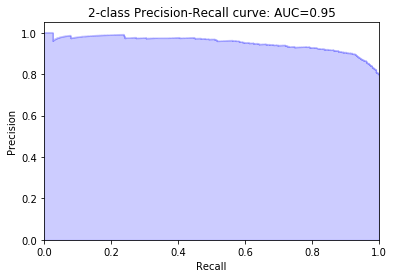

In [14]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(
          average_precision))
plt.show()

In [15]:
import matplotlib.pyplot as plt
import scikitplot.plotters as skplt

In [ ]:
skplt.plot_learning_curve(grid_search, docs_train, y_train)
plt.show()

In [ ]:
# Test some specific (new) examples
from newspaper import Article
import requests
url = 'https://deepmind.com/blog/cognitive-psychology/'
r = requests.get(url, verify=False) # False only because of local proxy issues.
article = Article(url, fetch_images=False)
article.download(input_html=r.text)
article.parse()
hit1 = article.text
hit1[:100]

In [ ]:
from newspaper import Article
import requests
url = 'https://deepmind.com/blog/cognitive-psychology/'
r = requests.get(url, verify=False)
article = Article(url, fetch_images=False)
article.download(input_html=r.text)
article.parse()
hit1 = article.text
url = 'https://theconversation.com/teaching-machines-to-understand-and-summarize-text-78236'
r = requests.get(url, verify=False)
article = Article(url, fetch_images=False)
article.download(input_html=r.text)
hit2 = article.text
url = 'https://www.theguardian.com/football/2017/jul/07/chelsea-romelu-lukaku-offer-match-manchester-united'
r = requests.get(url, verify=False)
article = Article(url, fetch_images=False)
article.download(input_html=r.text)
article.parse()
miss1 = article.text
url = 'https://arstechnica.com/business/2017/07/renewables-have-briefly-exceeded-nuclear-for-the-first-time-in-decades/'
r = requests.get(url, verify=False)
article = Article(url, fetch_images=False)
article.download(input_html=r.text)
article.parse()
miss2 = article.text

In [ ]:
url = 'https://arstechnica.com/tech-policy/2017/09/jury-finds-nintendo-wii-infringes-dallas-inventors-patent-awards-10m/'
r = requests.get(url, verify=False)
article = Article(url, fetch_images=False)
article.download(input_html=r.text)
article.parse()
miss3 = article.text

In [ ]:
docs_new = [hit1, hit2, miss1, miss2, miss3]
predicted = grid_search.predict(docs_new)
print(predicted)
for doc, category in zip(['hit1', 'hit2', 'miss1', 'miss2', 'miss3'], predicted):
     print('%r => %s' % (doc, dataset.target_names[category]))

In [ ]:
grid_search.decision_function(docs_new)

In [ ]:
from sklearn.naive_bayes import BernoulliNB
pipeline = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.95, stop_words='english')),
    ('clf', BernoulliNB()),
])
pipeline.fit(docs_train, y_train)

In [ ]:
y_predicted = pipeline.predict(docs_test)
print(metrics.classification_report(y_test, y_predicted,
                                    target_names=dataset.target_names))

In [ ]:
cm = metrics.confusion_matrix(y_test, y_predicted)
print(cm)

In [ ]:
docs_new = [hit1, hit2, miss1, miss2, miss3]
predicted = pipeline.predict(docs_new)
print(predicted)
for doc, category in zip(['hit1', 'hit2', 'miss1', 'miss2', 'miss3'], predicted):
     print('%r => %s' % (doc, dataset.target_names[category]))

In [ ]:
pipeline.predict_proba(docs_new)